In [ ]:
from datetime import datetime, timedelta
import logging
import os
import io
import pandas
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

# HDF5 Analysis
Each run of the fatigue test saves some data in an HDF5 file.  The idea is that we can use this data to verify the microscope was working properly, and if it broke, we can work back to figure out when it broke.  The data recorded, particularly at STICLab, isn't always good; there were some issues with illumination particularly in the earlier data, that meant some of the results are fairly meaningless.  However, the runtime should still be recorded accurately, so hopefully we do have a way to verify how long the microscope ran for at the very least.

I've pulled in some helpful utility functions from ``fatigue_test_plot.py`` which is a slightly refactored version of the data analysis script that was run over each file before uploading (to generate a PDF and remove the images saved into the file for debug purposes).

In [ ]:
import fatigue_test_plot as ftp
responses = pandas.read_csv("curated_responses.csv")
for k in ["timestamp", "start", "stop"]:
    responses[k] = pandas.to_datetime(responses[k]) # datetime values are saved in CSV as strings
hdf5_response_folder = r"..\..\Google Drive\WaterScope+STICLab\Fatigue Testing\Untitled form (File responses)\Upload the HDF5 file produced by the fatigue testing script (File responses)"

def data_file_for_row(i):
    """Return the i-th data file"""
    return h5py.File(os.path.join(hdf5_response_folder, responses["data_filename"][i]), mode="r")

Let's get started by looking at one of the runs that I know is good - e.g. the last entry, which is one I uploaded.

In [3]:
df = data_file_for_row(len(responses)-1)
if len(df) > 1:
    logging.warning(f"The file contained more than one data group")
data_group = list(df.values())[-1]

In [4]:
camera_datasets = ftp.numeric_items(data_group, "data_cam")
stage_datasets = ftp.numeric_items(data_group, "data_stage")
time_datasets = ftp.numeric_items(data_group, "data_time")

In [5]:
start_time = ftp.timestamp_to_datetime(camera_datasets[0])
stop_time = ftp.timestamp_to_datetime(camera_datasets[-1])
print(f"Ran for {stop_time - start_time}, started at {start_time}")

cycle, cam_coords, stage_coords, times = ftp.combine_datasets(
        camera_datasets, stage_datasets, time_datasets)
print(f"That was {len(times) / cycle} cycles.")
    
row = responses.iloc[-1, :]
print(f"Response said it ran for {row['stop'] - row['start']}, started at {row['start']}")

Ran for 11 days, 23:10:29.493100, started at 2020-03-25 04:41:05.560783
That was 3857.0 cycles.
Response said it ran for 11 days 23:10:00, started at 2020-03-25 04:41:00


We can run this over the whole list of responses, and add columns for those bits of information.

In [8]:
from contextlib import closing
from tqdm.auto import tqdm

# Add empty columns to the data frame
for colname in ["h5_start", "h5_stop", "h5_runtime", "cycles"]:
    if colname not in responses.columns:
        responses.insert(len(responses.columns), colname, [None]*len(responses))
    
for i in tqdm(range(len(responses))):
    try:
        with closing(data_file_for_row(i)) as df:
            if len(df) > 1:
                logging.warning(f"The file for row {i} contained more than one data group")
            data_group = list(df.values())[-1]
            time_datasets = ftp.numeric_items(data_group, "data_time")
            responses.loc[i, "h5_start"] = ftp.timestamp_to_datetime(time_datasets[0])
            responses.loc[i, "h5_stop"] = ftp.timestamp_to_datetime(time_datasets[-1])
            responses.loc[i, "h5_runtime"] = timedelta(seconds=time_datasets[-1][-1] - time_datasets[0][0])
            responses.loc[i, "cycles"] = len(time_datasets)//4
    except Exception as e:
        logging.warning(f"Exception on row {i}: {e}")
        
for colname in ["h5_start", "h5_stop"]:
    responses[colname] = pandas.to_datetime(responses[colname])

The rows where we got ``join() argument must be str or bytes`` are the ones where the file was missing entirely, so we couldn't even construct the filename.  There are a few more rows that failed, and it looks like in each case the problem was that the HDF5 file was somehow corrupted.  I've not looked into this in great detail, but I know there were some issues transferring files off the Pi SD cards - that could well be the culprit.  Files for rows 0 and 17 contained more than one group, which strongly suggests they weren't "summary" files.  Unfortunately I have no way of telling which of the groups is the correct one, so I may as well treat these as being corrupted.  This means there are, in total, 10 entries in the log not accompanied by valid HDF5 files, which seems like a good success rate.

The next challenge is to check the HDF5 files corroborate the data in the form.  I'll run through and check the recovered start/end times and durations.

In [10]:
def to_hours(td):
    """Convert a timedelta to hours"""
    return td/timedelta(hours=1)

issues_by_row = {}
for i in range(len(responses)):
    row = responses.loc[i,:]
    issues = []
    if np.abs(to_hours(row['start'] - row['h5_start'])) > 24:
        issues.append("start")
    if np.abs(to_hours(row['stop'] - row['h5_stop'])) > 24:
        issues.append("stop")
    #if np.abs((row['stop']-row['start'])/(row['h5_stop']-row['h5_start']) - 1) > 0.1:
    if np.abs(to_hours((row['stop']-row['start'])-(row['h5_stop']-row['h5_start']))) > 24:
        issues.append("duration")
    if len(issues) > 0:
        issues_by_row[i] = issues
        print(f"Row {i}: {', '.join(issues)}")

Row 3: start, stop
Row 14: start, duration
Row 16: start
Row 19: start, duration
Row 20: start, duration
Row 21: start, duration
Row 22: start, duration
Row 41: duration
Row 85: stop, duration
Row 86: start, stop
Row 90: start, stop, duration
Row 91: stop, duration
Row 93: start, stop
Row 94: start, stop
Row 96: start, stop
Row 97: start, stop
Row 98: start, stop
Row 99: start, stop
Row 100: start, stop
Row 101: stop, duration
Row 102: start, stop
Row 103: start, stop
Row 104: start, stop
Row 105: start, stop
Row 106: start, stop
Row 107: start, stop
Row 108: start, stop
Row 123: start, duration
Row 135: stop, duration
Row 161: start, stop
Row 162: start, stop
Row 163: start, stop
Row 164: start, stop
Row 165: start, stop
Row 166: start, stop
Row 167: start, stop
Row 168: start, stop
Row 169: start, stop
Row 170: start, stop
Row 171: start, stop
Row 172: start, stop
Row 173: start, stop
Row 174: start, stop
Row 175: start, stop
Row 176: start, stop
Row 177: start, stop
Row 178: start, 

In [11]:
wrong_durations = len([True for v in issues_by_row.values() if "duration" in v])
wrong_starts = len([True for v in issues_by_row.values() if "start" in v])
wrong_stops = len([True for v in issues_by_row.values() if "stop" in v])
print(f"The survey and the files disagree on {wrong_durations} durations,")
print(f"{wrong_starts} start times, and {wrong_stops} stop times.")

The survey and the files disagree on 42 durations,
160 start times, and 148 stop times.


The incorrect start/end times shouldn't surprise us too much, because the Pi doesn't have a real time clock.  That means any time it gets powered off, it won't have the right time until it is connected to the internet again.  However, the runtimes as reported by the data should be correct.  10 of the rows will have all three times wrong, because the file was missing or corrupt.  That leaves 32 where the duration is mis-reported by more than a day.

In [15]:
responses["form_dt"] = responses["stop"] - responses["start"]
responses["h5_dt"] = responses["h5_stop"] - responses["h5_start"]

responses.loc[
    [k for k, v in issues_by_row.items() if "duration" in v], 
    ["start", "h5_start", "stop", "h5_stop", "form_dt", "h5_dt", "h5_runtime"]
]

start                   h5_start                stop  \
14  2019-02-11 13:30:00 2019-02-06 06:16:43.271327 2019-02-12 10:30:00   
19  2019-01-13 11:46:00 2019-02-13 08:53:35.408440 2019-02-14 10:23:00   
20  2019-02-18 09:53:00 2019-02-14 07:35:58.241454 2019-02-19 09:24:00   
21  2019-02-18 09:18:00 2019-02-12 07:27:07.050258 2019-02-19 09:32:00   
22  2019-02-18 09:33:00 2019-02-14 07:38:03.047820 2019-02-19 09:29:00   
41  2019-02-27 12:20:00 2019-02-27 09:01:53.329357 2019-02-27 11:03:00   
85  2019-03-16 09:53:00 2019-03-16 05:21:28.203269 2019-03-18 12:53:00   
90  2019-03-19 13:24:00 2019-03-15 09:32:46.421816 2019-03-24 10:36:00   
91  2019-03-19 13:25:00 2019-03-19 09:38:35.083225 2019-03-24 10:29:00   
101 2019-05-17 13:24:00 2019-05-17 11:21:22.177229 2019-05-18 13:31:00   
123 2019-06-08 09:11:00 2019-06-07 08:21:38.775872 2019-06-10 08:15:00   
135 2019-06-14 10:07:00 2019-06-14 10:09:11.414957 2019-06-05 10:11:00   
197 2019-08-20 08:55:00 2019-08-11 12:04:16.934266 2019-08-21 09:02:00   
205 2019-08-22 11:25:00 2019-07-04 11:30:01.566445 2019-08-23 11:43:00   
218 2019-08-20 08:59:00 2019-08-10 18:04:57.245137 2019-08-21 09:02:00   
239 2019-09-12 09:03:00 2019-09-09 21:02:48.221656 2019-09-13 09:07:00   
242 2019-09-13 09:27:00 2019-09-10 21:19:42.438988 2019-09-14 09:29:00   
260 2019-09-09 01:45:00 2019-08-29 12:06:42.061172 2019-09-26 09:25:00   
314 2019-10-25 09:21:00 2019-10-23 09:21:45.184012 2019-10-26 08:59:00   
338 2019-11-02 10:04:00 2019-11-02 10:05:23.004745 2019-11-04 08:38:00   
339 2019-11-02 10:59:00 2019-11-02 11:01:02.864304 2019-11-04 08:38:00   
340 2019-11-02 11:02:00 2019-11-02 11:03:44.513435 2019-11-04 08:48:00   
341 2019-11-04 08:38:00 2019-11-02 13:31:43.620682 2019-11-04 12:36:00   
342 2019-11-04 08:40:00 2019-11-02 13:33:23.929340 2019-11-04 12:36:00   
395 2019-11-23 09:11:00 2019-11-23 09:12:53.106770 2019-11-25 09:11:00   
396 2019-11-23 09:18:00 2019-11-23 09:17:43.002370 2019-11-25 09:18:00   
397 2019-11-23 10:08:00 2019-11-23 09:25:14.152172 2019-11-25 10:30:00   
398 2019-11-25 10:37:00 2019-11-23 13:36:34.222513 2019-11-26 09:14:00   
399 2019-11-25 10:48:00 2019-11-23 13:47:29.245389 2019-11-26 10:48:00   
400 2019-11-25 10:50:00 2019-11-23 13:33:57.876716 2019-11-26 10:51:00   
457 2019-12-23 08:44:00 2019-12-20 13:34:38.412223 2019-12-24 08:44:00   
459 2020-12-24 08:50:00 2019-12-24 08:51:27.563335 2020-01-27 10:20:00   
460 2020-12-24 12:24:00 2019-12-24 12:25:27.007957 2020-01-27 10:40:00   
464 2020-12-24 08:43:00 2019-12-24 08:45:29.984700 2020-01-27 10:30:00   
490 2020-02-08 10:17:00 2020-01-11 10:22:57.588909 2020-02-10 08:57:00   
509 2020-04-08 12:29:00 2020-01-10 20:28:43.761034 2020-04-09 12:30:00   
510 2020-04-08 12:30:00 2020-01-22 11:34:43.111839 2020-04-09 12:38:00   
515 2020-04-11 10:01:00 2020-01-14 19:27:12.324333 2020-04-14 08:40:00   
517 2020-04-11 10:07:00 2020-01-26 10:38:17.967198 2020-04-14 08:54:00   
522 2020-04-14 08:59:00 2020-01-16 20:14:59.749984 2020-04-16 09:02:00   
524 2020-04-16 09:07:00 2020-01-17 20:23:22.273871 2020-04-17 09:18:00   
526 2020-04-16 09:14:00 2020-01-29 10:47:35.304687 2020-04-17 09:39:00   

                       h5_stop             form_dt                   h5_dt  \
14  2019-02-12 07:13:10.486490     0 days 21:00:00  6 days 00:56:27.215163   
19  2019-02-14 07:18:28.348881    31 days 22:37:00  0 days 22:24:52.940441   
20  2019-02-19 06:21:08.823826     0 days 23:31:00  4 days 22:45:10.582372   
21  2019-02-19 06:32:17.946685     1 days 00:14:00  6 days 23:05:10.896427   
22  2019-02-19 06:27:52.716719     0 days 23:56:00  4 days 22:49:49.668899   
41  2019-02-28 08:03:16.443350   -1 days +22:43:00  0 days 23:01:23.113993   
85  2019-03-17 06:03:03.723089     2 days 03:00:00  1 days 00:41:35.519820   
90  2019-03-16 05:55:26.889257     4 days 21:12:00  0 days 20:22:40.467441   
91  2019-03-21 20:48:52.142046     4 days 21:04:00  2 days 11:10:17.058821   
101 2019-05-17 11:24:33.520336     1 days 00:07:00  0 d

How do we fix these?  A reasonable place to start might be looking at the ratio of the reported time to the number of cycles in the dataset.  This should be constant, because all the microscopes should move at the same speed.  If it's much higher, or much lower, than we expect, that's reason to suppose the duration is reported incorrectly.  We also have three measures of duration - difference of start and end times as reported by the user, as reported by the HDF5 file timestamps, and as recorded in the time column of the HDF5 data.  It's possible we could use a majority vote to fix this, though of course the two HDF5 measures might not be independent, for example if the Pi updated its system clock during the run we'd expect an error in both datasets.  However, in that case, it ought to show up in the individual time points, as one really long (or negative) delay.

Mean: 37.0 s/cycle
Mode: 23.0 s/cycle


C:\Users\rwb34\dev\venvs\win-py3-scipy\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\rwb34\dev\venvs\win-py3-scipy\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


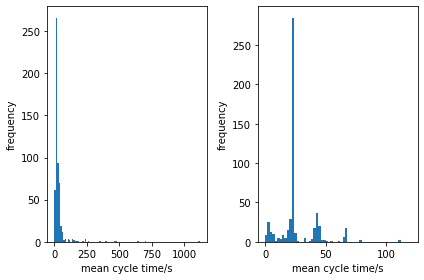

In [16]:
responses["h5_runtime"] = pandas.to_timedelta(responses["h5_runtime"])
responses["seconds_per_cycle"] = responses["h5_runtime"]/timedelta(seconds=1)/responses["cycles"]
print(f"Mean: {np.mean(responses['seconds_per_cycle']):.1f} s/cycle")
f, ax = plt.subplots(1,2)   
_ = ax[0].hist(responses["seconds_per_cycle"], bins=100)
frequencies, edges, _patches = ax[1].hist(responses["seconds_per_cycle"], bins=np.linspace(0, 120, 61))
imax = np.argmax(frequencies)
mode = (edges[imax] + edges[imax + 1])/2
print(f"Mode: {mode:.1f} s/cycle")
for a in ax:
    a.set_xlabel("mean cycle time/s")
    a.set_ylabel("frequency")
f.tight_layout()

Let's explore this a bit further.  Recall that we saved the data from the final dataset way back at the start of this notebook: ``cycle, cam_coords, stage_coords, times`` tell us the number of points per cycle, and the motion as recorded by the camera and stage.  Of interest here is ``times``, which holds the time in seconds since the start of the fatigue test.  Let's plot this for the first and last cycle:

Text(0, 0.5, 'dt/seconds')

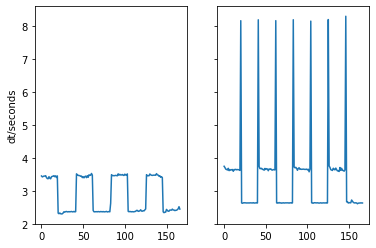

In [17]:
f, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(np.diff(times[:2*cycle]))
ax[1].plot(np.diff(times[-2*cycle:]))
ax[0].set_ylabel("dt/seconds")

What we see here all makes sense: the time-per-point alternates between about 3.5 seconds and 2.5 seconds.  This makes sense; we move forwards for 21 points (i.e. 20 moves, with points before and after each move), then stay static for 21 points, then move back, then stay static.  The extra second per point is the time spent moving the stage.  It's curious that at the end of the run, the last point of each set takes much longer.  I suspect this is because the file has become large, and it takes longer to write the data to disk (or possibly to memory - I'm not totally sure how the file is buffered).  The write is performed at the end of each block of 21 points, so it makes sense that this grows roughly linearly as the test progresses.  It should be possible to extract the different phases:

Text(0.5, 0, 'Cycle number')

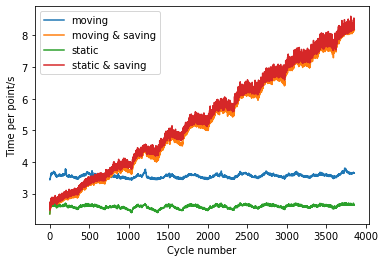

In [18]:
m = cycle // 4
traces = {
    "moving": list(range(0, m-1)) + list(range(m*2, m*3-1)),
    "moving & saving": [m-1, m*3-1],
    "static": list(range(m, m*2-1)) + list(range(m*3, m*4-1)),
    "static & saving": [m*2-1, m*4-1],
}
dt = np.diff(times)
f, ax = plt.subplots(1,1)
N = len(dt) // cycle
for name, offsets in traces.items():
    sliced_dt = np.zeros(N)
    for offset in offsets:
        sliced_dt += dt[offset:N*cycle + offset:cycle]
    sliced_dt /= len(offsets)
    ax.plot(sliced_dt, label=name)
ax.legend()
ax.set_ylabel("Time per point/s")
ax.set_xlabel("Cycle number")

If we want to do an automated analysis, maybe focusing on the cycle time is better than the individual ``dt`` values; that's much faster too, as we can just take the mean of each block of times:

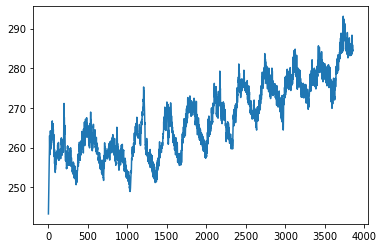

In [19]:
with closing(data_file_for_row(len(responses)-1)) as df:
    data_group = list(df.values())[-1]
    time_datasets = ftp.numeric_items(data_group, "data_time")
    block_times = np.array([np.mean(times) for times in time_datasets])
    cycle_times = np.mean(block_times.reshape(block_times.shape[0]//4, 4), axis=1) # cycles are 4 blocks long 
plt.plot(np.diff(cycle_times))

There's a definite periodicity there, which is curious - but I am not sure it's worth looking into.  It probably tells us something very subtle about the Raspberry Pi's filesystem or something...  Let's run this for every data file, and see what we get...

In [42]:
cycle_times_by_row = []
for i in tqdm(range(len(responses))):
    try:
        with closing(data_file_for_row(i)) as df:
            data_group = list(df.values())[-1]
            time_datasets = ftp.numeric_items(data_group, "data_time")
            block_times = np.array([np.mean(t) for t in time_datasets])
            N = block_times.shape[0]//4
            cycle_times = np.mean(block_times[:N*4].reshape(N, 4), axis=1) # cycles are 4 blocks long 
            cycle_times_by_row.append(cycle_times)
    except Exception as e:
        logging.warning(f"Row {i}: failed to analyse timing - {e}")
        cycle_times_by_row.append(None)



Mode: 270.3 s/cycle or 3.2 s/point


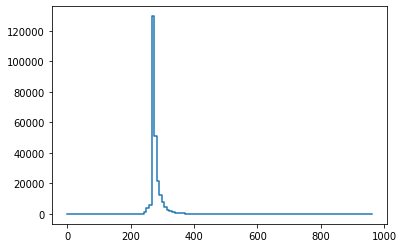

In [43]:
edges = np.linspace(0,960,120)
histogram = np.zeros(len(edges) - 1)
for i in tqdm(range(len(cycle_times_by_row))):
    if cycle_times_by_row[i] is not None:
        histogram += np.histogram(np.diff(cycle_times_by_row[i]), edges)[0]
hist_x = np.zeros(2*len(histogram))
hist_x[0::2] = edges[:-1]
hist_x[1::2] = edges[1:]
hist_y = np.zeros_like(hist_x)
hist_y[0::2] = histogram
hist_y[1::2] = histogram
plt.plot(hist_x, hist_y)

imax = np.argmax(histogram)
mode = (edges[imax] + edges[imax + 1])/2
print(f"Mode: {mode:.1f} s/cycle or {mode/cycle:.1f} s/point")
modal_cycle_time = mode

In [44]:
threshold = modal_cycle_time * 2
responses["corrected_runtime"] = responses["h5_runtime"]

for i, cycle_times in tqdm(enumerate(cycle_times_by_row)):
    if cycle_times is None or len(cycle_times) < 2:
        continue
    dt = np.diff(cycle_times)
    outliers = dt > threshold
    if np.any(outliers):
        print(f"Row {i}: {np.sum(outliers)} found, taking the elapsed time "
              f"from {np.sum(dt)/3600:.1f}h to {np.sum(dt[np.logical_not(outliers)])/3600:.1f}h")
        responses.loc[i,"corrected_runtime"] = timedelta(seconds=np.sum(dt[np.logical_not(outliers)]))
        print("   ", end="")
        for i, delta in enumerate(dt):
            if delta > threshold:
                print(f"{i}: {delta:.1f}, ", end="")
        print(f"out of {len(dt)}")
    else:
        print(f"Row {i}: no outliers, max cycle time {np.max(dt):.1f}, shape {dt.shape}")
        pass
    if np.any(dt < 0):
        print("Detected points with dt <0")
    #print(dt)

Row 2: no outliers, max cycle time 280.1, shape (151,)
Row 3: no outliers, max cycle time 280.1, shape (151,)
Row 4: no outliers, max cycle time 278.8, shape (44,)
Row 5: no outliers, max cycle time 278.8, shape (44,)
Row 6: no outliers, max cycle time 283.8, shape (214,)
Row 7: no outliers, max cycle time 362.3, shape (595,)
Row 8: no outliers, max cycle time 360.8, shape (588,)
Row 9: no outliers, max cycle time 283.2, shape (176,)
Row 10: 1 found, taking the elapsed time from 18.4h to 17.7h
   0: 2466.5, out of 231
Row 11: no outliers, max cycle time 288.2, shape (225,)
Row 12: no outliers, max cycle time 288.2, shape (225,)
Row 13: no outliers, max cycle time 425.9, shape (783,)
Row 14: 2 found, taking the elapsed time from 144.8h to 20.7h
   21: 276500.5, 22: 170261.3, out of 270
Row 15: no outliers, max cycle time 277.2, shape (16,)
Row 16: 2 found, taking the elapsed time from 46.8h to 23.8h
   6: 21833.7, 7: 61037.7, out of 307
Row 18: no outliers, max cycle time 296.1, shape (

   260: 557.1, 261: 1130.2, out of 279
Row 358: no outliers, max cycle time 285.2, shape (260,)
Row 359: no outliers, max cycle time 285.2, shape (260,)
Row 360: no outliers, max cycle time 286.9, shape (574,)
Row 361: no outliers, max cycle time 299.6, shape (569,)
Row 362: no outliers, max cycle time 302.5, shape (307,)
Row 363: no outliers, max cycle time 282.4, shape (261,)
Row 364: no outliers, max cycle time 289.9, shape (314,)
Row 365: no outliers, max cycle time 293.8, shape (314,)
Row 366: no outliers, max cycle time 293.8, shape (314,)
Row 367: 1 found, taking the elapsed time from 24.0h to 23.8h
   14: 708.8, out of 317
Row 368: no outliers, max cycle time 305.1, shape (312,)
Row 369: no outliers, max cycle time 284.1, shape (314,)
Row 370: no outliers, max cycle time 288.6, shape (316,)
Row 371: no outliers, max cycle time 365.3, shape (281,)
Row 372: 2 found, taking the elapsed time from 24.5h to 23.8h
   285: 1506.8, 286: 968.3, out of 303
Row 373: 2 found, taking the ela

In [51]:
responses.loc[
    responses["form_dt"] > responses["corrected_runtime"] + timedelta(hours=12), 
    ["start", "h5_start", "form_dt", "h5_runtime", "corrected_runtime"]
]

start                   h5_start          form_dt  \
5   2019-02-01 16:00:00 2019-02-01 08:04:20.505880  0 days 18:00:00   
7   2019-02-01 17:00:00 2019-02-02 07:11:40.900918  2 days 18:00:00   
8   2019-02-01 17:00:00 2019-02-02 07:33:30.356219  2 days 18:00:00   
15  2019-02-11 15:22:00 2019-02-11 12:23:37.114255  0 days 19:08:00   
19  2019-01-13 11:46:00 2019-02-13 08:53:35.408440 31 days 22:37:00   
28  2019-02-20 09:48:00 2019-02-20 06:49:45.027437  1 days 00:11:00   
47  2019-03-01 11:42:00 2019-03-01 08:43:45.280015  0 days 23:59:00   
49  2019-03-02 00:08:00 2019-03-02 08:27:35.680114  2 days 10:12:00   
50  2019-03-04 10:38:00 2019-03-04 07:38:57.362131  1 days 00:28:00   
51  2019-03-04 10:55:00 2019-03-04 07:31:34.036577  1 days 00:05:00   
85  2019-03-16 09:53:00 2019-03-16 05:21:28.203269  2 days 03:00:00   
90  2019-03-19 13:24:00 2019-03-15 09:32:46.421816  4 days 21:12:00   
91  2019-03-19 13:25:00 2019-03-19 09:38:35.083225  4 days 21:04:00   
101 2019-05-17 13:24:00 2019-05-17 11:21:22.177229  1 days 00:07:00   
159 2019-06-25 15:56:00 2019-06-26 09:53:06.644652  1 days 17:54:00   
163 2019-07-23 12:06:00 2019-07-17 11:14:32.433904  1 days 01:35:00   
178 2019-08-01 09:38:00 2019-07-24 03:54:52.693702  1 days 00:01:00   
181 2019-08-03 09:56:00 2019-07-25 04:07:18.463921  1 days 22:54:00   
260 2019-09-09 01:45:00 2019-08-29 12:06:42.061172 17 days 07:40:00   
295 2019-10-03 11:05:00 2019-10-04 11:17:39.074948  1 days 00:00:00   
311 2019-10-24 09:20:00 2019-10-25 09:29:08.159173  1 days 00:00:00   
321 2019-10-28 08:28:00 2019-10-28 04:18:45.495815  1 days 00:01:00   
338 2019-11-02 10:04:00 2019-11-02 10:05:23.004745  1 days 22:34:00   
339 2019-11-02 10:59:00 2019-11-02 11:01:02.864304  1 days 21:39:00   
340 2019-11-02 11:02:00 2019-11-02 11:03:44.513435  1 days 21:46:00   
361 2019-11-09 12:43:00 2019-11-09 12:28:50.834615  2 days 07:56:00   
393 2019-11-22 09:10:00 2019-11-23 09:17:43.002370  1 days 00:00:00   
395 2019-11-23 09:11:00 2019-11-23 09:12:53.106770  2 days 00:00:00   
396 2019-11-23 09:18:00 2019-11-23 09:17:43.002370  2 days 00:00:00   
397 2019-11-23 10:08:00 2019-11-23 09:25:14.152172  2 days 00:22:00   
404 2019-11-27 09:26:00 2019-11-27 09:27:54.816731  1 days 00:16:00   
456 2019-12-23 08:39:00 2019-12-20 13:22:42.719431  1 days 00:00:00   
480 2020-02-01 13:10:00 2020-01-04 13:28:45.068410  2 days 07:23:00   
490 2020-02-08 10:17:00 2020-01-11 10:22:57.588909  1 days 22:40:00   
502 2020-04-06 08:44:00 2020-01-07 20:44:00.732652  1 days 00:05:00   
503 2020-04-06 12:29:00 2020-01-19 14:20:24.084914  1 days 20:08:00   
515 2020-04-11 10:01:00 2020-01-14 19:27:12.324333  2 days 22:39:00   
517 2020-04-11 10:07:00 2020-01-26 10:38:17.967198  2 days 22:47:00   
522 2020-04-14 08:59:00 2020-01-16 20:14:59.749984  2 days 00:03:00   

                 h5_runtime       corrected_runtime  
5    0 days 03:27:59.789685  0 days 03:27:59.789685  
7    2 days 01:40:48.514576  2 days 01:40:48.514576  
8    2 days 01:29:39.967104  2 days 01:29:39.967104  
15   0 days 01:19:48.891630  0 days 01:19:48.891630  
19   0 days 22:26:04.307685  0 days 22:26:04.307685  
28   0 days 05:22:13.148149  0 days 05:22:13.148149  
47   0 days 03:14:46.642986  0 days 03:14:46.642986  
49   1 days 22:49:44.274566  1 days 21:53:15.038336  
50   0 days 08:00:21.004085  0 days 08:00:21.004085  
51   0 days 08:08:06.567429  0 days 07:29:44.233080  
85   1 days 00:42:45.958803  1 days 00:42:45.958803  
90   0 days 20:23:52.668848  0 days 20:23:52.668848  
91   2 days 11:11:03.708246  2 days 11:11:03.708246  
101  0 days 00:04:28.236058  0 days 00:04:28.236058  
159  0 days 23:59:44.971230  0 days 23:59:44.971230  
163  0 days 08:03:03.121094  0 days 08:03:03.121094  
178  0 days 06:58:00.273102  0 days 06:58:00.273102  
181  0 days 23:57:11.449791  0 days 23:57:11.449791  
260 10 days 23:58:41.677275 10 days 23:58:41.677275  
295  0 days 02:11:47.157681  0 days 02:11:47.157681  
311  0 days 02:57:59.948446  0 days 02:57:5

In [52]:
responses.to_csv("responses_with_runtime.csv")

In [41]:
len(cycle_times_by_row)

28